In [145]:
import torch
from torch import nn #建立模型的库
from torch.nn import functional as F#损失函数 激活函数
from torch import optim#优化器 SGD
from torch.utils.data import Dataset, DataLoader#读取外部数据 将数据加载入模型
import torchvision#数据预处理 内置数据集
from matplotlib import pyplot as plt#画图
import torchvision.transforms as T#数据预处理
import os#文件处理
from PIL import Image#载入 显示图片
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [146]:
def plot_curve(data):#画出损失值的下降曲线
    fig = plt.figure()
    plt.plot(range(len(data)), data, color='blue')
    plt.legend(['value'], loc='upper right')
    plt.xlabel('step')
    plt.ylabel('value')
    plt.savefig('three-loss.png')
    plt.show()

In [147]:
# def plot_image(img, label, name):#画出样本的图像

#     fig = plt.figure()
#     img = img.detach().numpy()
#     for i in range(4):#循环了四次 画四个子图
#         plt.subplot(2, 2, i + 1)
#         plt.tight_layout()
#         plt.imshow(img[i].transpose(1,2,0))#img[0]  3 96 96   96 96 3
#         plt.title("{}: {}".format(name, label[i].item()))
#         plt.xticks([])
#         plt.yticks([])
#     plt.show()
def plot_image(img, label, name):
    # 确定要显示的图片数量，取批次大小和4的较小值
    num_images = min(img.shape[0], 4)
    plt.figure(figsize=(10, 8))
    
    for i in range(num_images):
        plt.subplot(2, 2, i + 1)
        plt.tight_layout()
        plt.imshow(img[i].permute(1, 2, 0))  # 使用permute代替transpose，效果相同
        plt.title("{}: {}".format(name, label[i].item()))
        plt.xticks([])
        plt.yticks([])
    
    plt.show()

In [148]:
# def one_hot(label, depth=3):#把标签y y是数值标签 良性 恶性 转换成y_onehot （1 0） （0 1） depth是标签（类别）的数量
#     out = torch.zeros(label.size(0), depth)
#     idx = torch.LongTensor(label).view(-1, 1)
#     out.scatter_(dim=1, index=idx, value=1)
#     return out
def one_hot(label, depth=3):
    # 创建一个全零张量，形状为 (batch_size, depth)，设备与 label 一致
    out = torch.zeros(label.size(0), depth, device=label.device)
    # 将 label 转换为长整型张量，并保持在同一设备上
    idx = torch.tensor(label, dtype=torch.long, device=label.device).view(-1, 1)
    # 使用 scatter_ 方法将对应位置的值设置为 1
    out.scatter_(dim=1, index=idx, value=1)
    return out

In [149]:
class MyDataset(Dataset):# 建立自己的数据集 从特定的 路径 把图片 读进来

    def __init__(self, flag='train'):#数据增强方法
        assert flag in ['train', 'test', 'valid']#保证flag必须是训练 测试 或者验证
        self.flag = flag
        self.Animedata_path=[]#训练集 图片的路径的数组
        self.Animedata_testpath=[]#测试集图片路径的数组
        
        # 获取所有图片路径
        all_images = []
        for cls in ['0', '1', '2']:
            for img in os.listdir(f"影像/三分类/{cls}"):
                all_images.append((os.path.join(f"影像/三分类/{cls}/", img), int(cls)))
        
        # 划分训练集和测试集 (80% 训练, 20% 测试)
        import random
        random.shuffle(all_images)
        split_idx = int(len(all_images) * 0.9)
        
        # 分配到训练集和测试集
        for img_path, cls in all_images[:split_idx]:
            self.Animedata_path.append((img_path, cls))
        
        for img_path, cls in all_images[split_idx:]:
            self.Animedata_testpath.append((img_path, cls))
            
        self.resize_transform = T.Resize((96, 96))#把数据尺寸 归一化96 96
        self.transforms=T.ToTensor()#把图片由矩阵转化为张量Tensor
            
    def __getitem__(self, index):# MyDataset[0] 根据 索引值 返回 图片和标签
        # 根据索引返回数据
        if self.flag=='train':#训练过程 返回的训练数据
            image_path, label = self.Animedata_path[index]#是根据 索引值 index 去获取训练图片路径和标签
            image=Image.open(image_path)#根据获取的路径 把图片以矩阵的形式 读进来
            image=self.resize_transform(image)#对图片矩阵 进行 归一化
            image=self.transforms(image).float()#把矩阵转化为张量 再变为float类型

            return image, torch.tensor(label)#image是图片 label是标签
            
        elif self.flag=='test':#测试过程 返回的测试数据
            image_path, label = self.Animedata_testpath[index]#是根据 索引值 index 去获取测试图片路径和标签
            image=Image.open(image_path)#根据获取的路径 把图片以矩阵的形式 读进来
            image=self.resize_transform(image)#对图片矩阵 进行 归一化
            image=self.transforms(image).float()#把矩阵转化为张量 再变为float类型

            return image, torch.tensor(label)#image是图片 label是标签
    
    def __len__(self):
        # 返回数据的长度
        if self.flag=='train':
            return len(self.Animedata_path)
        elif self.flag=='test':
            return len(self.Animedata_testpath)

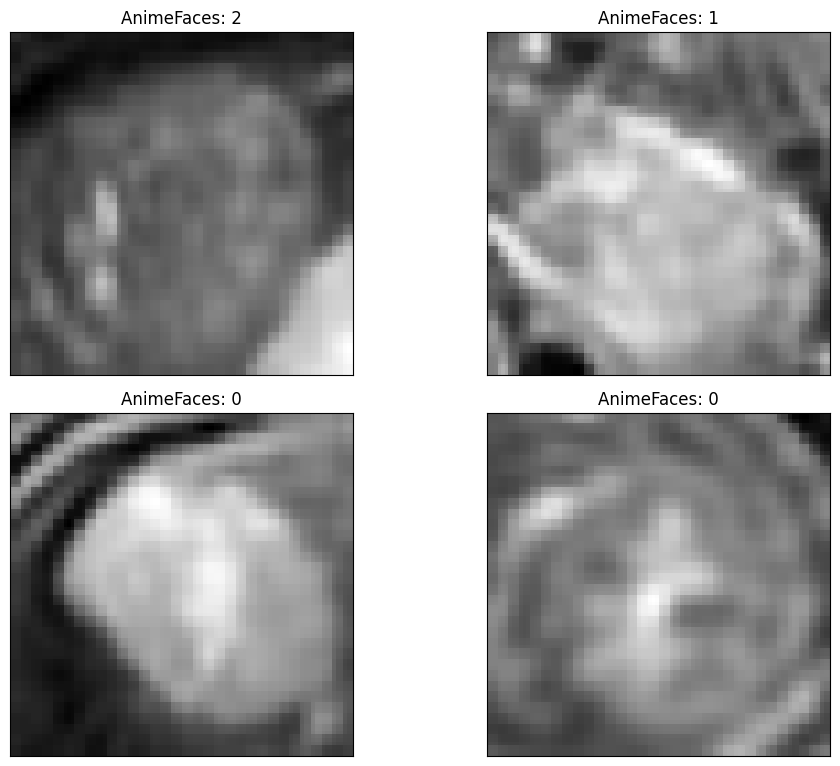

tensor([2, 1, 0, 0, 1, 2, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 2, 2, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 2, 0])

In [150]:
batch_size=64 #每一个训练的Step 送往模型中的图片的数量 当你数据很多的时候 可以设得很大 当样本分布分散时 可以设的比较大 当图片比较少 或者样本分布 比较集中 可以设一个比较小的值

train_loader = torch.utils.data.DataLoader(MyDataset(flag='train'),batch_size=batch_size, shuffle=True)
#迭代器 在for循环中 按循环次数 调用getitem函数 返回数据和标签 shuffle 对样本进行随机排序 返回训练集的数据
test_loader= torch.utils.data.DataLoader(MyDataset(flag='test'),batch_size=batch_size, shuffle=False)
#迭代器 返回测试集的数据

x,y=next(iter(train_loader)) # iter iteration 迭代 next函数之后 可以返回一组getitem中的数据
# x是图片 y是标签
plot_image(x,y,"AnimeFaces")#画出 读取的 图片
y

In [151]:
class Net1(nn.Module):#Net类 功能是 描述清楚 模型中包含的网络层数 每一层的类型 数据在模型中的一个传播路径
#resnet18 densenet senet googlenet
    def __init__(self):#构造函数 声明 所有需要在模型中出现的层
        super(Net1, self).__init__()
        self.conv1=nn.Conv2d(in_channels=4,out_channels=6,kernel_size=5)#96 96 4 ->92 92 6
        self.pool1=nn.MaxPool2d(kernel_size=2)#46 46 6
        self.conv2=nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)#42 42 16
        self.pool2=nn.MaxPool2d(kernel_size=2)#21 21 16
        self.fc1 = nn.Linear(21*21*16, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x=self.pool1(x)
        x = F.relu(self.conv2(x))
        x=self.pool2(x)
        x = x.view(x.size(0), 21*21*16)
        x = F.relu(self.fc1(x))
#激活函数relu可以替换leak—relu
        x = F.relu(self.fc2(x))

        x = self.fc3(x)

        return x#返回模型的预测结果

In [152]:
net = Net1()#建立Net类的实例net net是我们构建的模型
net = net.to(device)

#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, betas=(0.9,0.999), eps=1e-8, weight_decay=0, amsgrad=True)
#rmprop adagrad adam sgdm 学习率衰减和动量
#优化器 功能：实现梯度下降 net.parameters()模型的所有参数 
#lr learn rate 学习率 功能是 控制训练的速度 设太大会导致 损失值波动 太小则损失值下降速度慢
#momentum 动量 动量越大 越可能快速通过 平台期 鞍点和局部最优点 太大会导致损失值波动

C:\Users\31561\AppData\Local\Temp\ipykernel_22128\3255878472.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx = torch.tensor(label, dtype=torch.long, device=label.device).view(-1, 1)


0 0 0.13161608576774597
1 0 0.13913492858409882
2 0 0.1413186937570572
3 0 0.12252143025398254
4 0 0.12658846378326416
5 0 0.1286485195159912
6 0 0.10954505205154419
7 0 0.110887810587883
8 0 0.10788696259260178
9 0 0.10460929572582245
10 0 0.1070462167263031
11 0 0.09963016957044601
12 0 0.08689757436513901
13 0 0.09992396086454391
14 0 0.108218252658844
15 0 0.10509085655212402
16 0 0.11085065454244614
17 0 0.08925282955169678
18 0 0.084894560277462
19 0 0.09208041429519653
20 0 0.09582583606243134
21 0 0.08659007400274277
22 0 0.0988447293639183
23 0 0.07601868361234665
24 0 0.08739175647497177
25 0 0.088199183344841
26 0 0.09873019903898239
27 0 0.0758623331785202
28 0 0.08429472148418427
29 0 0.07331383228302002
30 0 0.08998799324035645
31 0 0.0576227530837059
32 0 0.07853247225284576
33 0 0.06221170350909233
34 0 0.06352181732654572
35 0 0.06860160082578659
36 0 0.05367710813879967
37 0 0.07325302064418793
38 0 0.06619663536548615
39 0 0.061078544706106186
40 0 0.0880212411284446

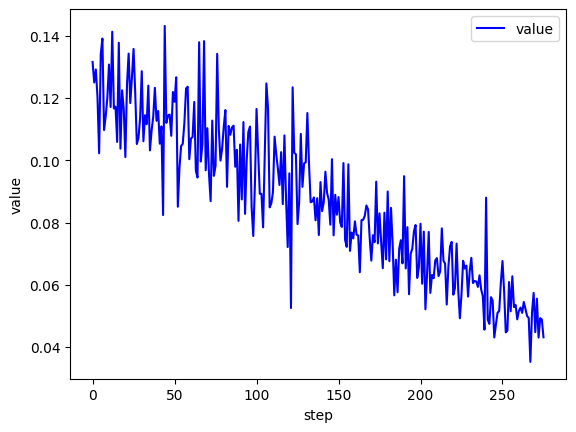

In [157]:
train_loss = []#用来装损失值的数组

for epoch in range(46):#控制训练的轮次 epoch range(epoch) epoch数量越大 则训练的次数越多
#训练次数 不是越多越好 在损失值收敛之后 重复训练 可能会导致过拟合

    for batch_idx, (x, y) in enumerate(train_loader):
#枚举函数 enumerate batch_idx是枚举的顺序值 从0 开始 可以用于表示输出图片batch位于所有数据中的第几组
#x代表 batchsize张图片 y代表batch_size个标签 数值标签 0，1
        # 将数据移动到GPU
        x = x.to(device)
        y = y.to(device)

        #x = x.view(x.size(0), 96*96*4)#把图片 拉伸成一维向量 x.size(0)==batch_size 4个96*96*4的向量

        out = net(x)#把数据x送入模型 得到预测结果out

        y_onehot = one_hot(y)#把数值标签 转换为 向量标签 0，1--》（1，0）（0，1）
        #y_onehot是向量标签

        loss = F.mse_loss(out, y_onehot)#F.mse_loss 均方误差损失函数 换成交叉熵损失 或者其他常用的损失函数
        #损失函数的输入 包含预测值 out和标签向量 y_onehot

        optimizer.zero_grad()#清空模型所有层的梯度
        loss.backward()#通过反向传播 计算每层 每个参数的损失值
        optimizer.step()#执行一次梯度下降
        #以上三步是固定的 无需修改

        train_loss.append(loss.item())#把计算的损失值 放入 损失数组里

        if batch_idx % 10 ==0:#每十个batch 打印一次 损失值
            print(epoch, batch_idx, loss.item())#epoch 波次 batch_id每波对应的batch位置  loss损失值

plot_curve(train_loss)#根据记录损失值的数组 画出损失下降曲线

test acc: 0.9512195121951219


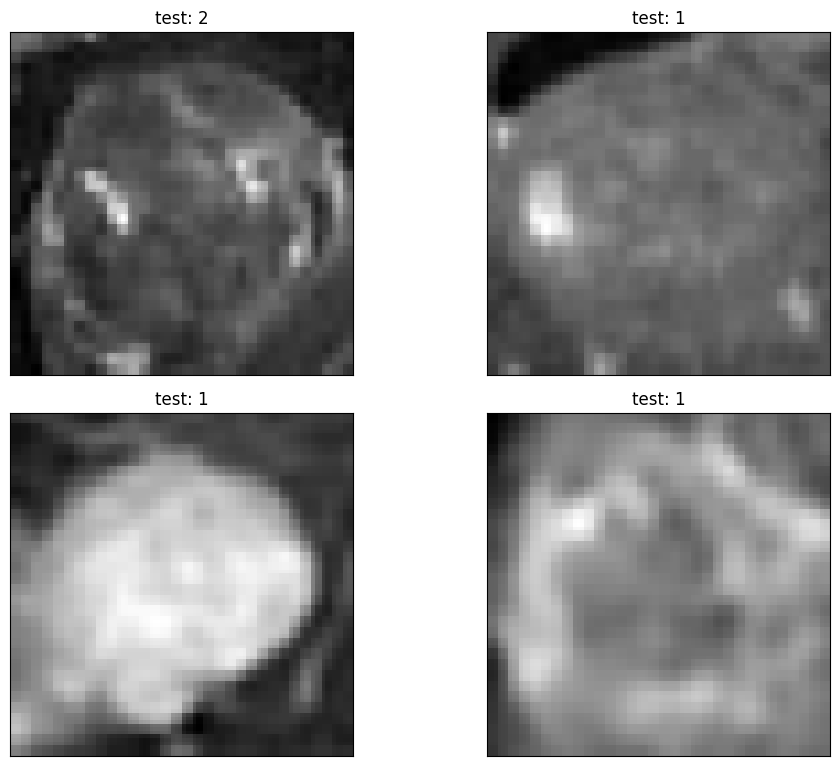

In [158]:
total_correct = 0#用来记录 所有数据中预测正确的样本数量
for x,y in test_loader:#从测试数据中 按batch依次读出图片和标签
    #x  = x.view(x.size(0), 96*96*4)#拉伸成向量
    # 使用GPU
    x = x.to(device)
    y = y.to(device)
    out = net(x)#把图片x输入模型

    pred = out.argmax(dim=1)#获取输出结果 最大值所在的维度 即为预测的类别信息
    #pred是预测的类别
    correct = pred.eq(y).sum().float().item()#比较数值标签y和预测的数值类别pred 并统计两者相同的次数
    #correct为y与pred相同的样本的数量
    total_correct += correct#把本batch中预测正确的样本数量 记录的 总预测正确的样本数量中
#准确率 为 预测正确的样本数量/所有的样本数量
total_num = len(test_loader.dataset)#计算测试集中所有的样本数量
acc = total_correct / total_num#计算准确率 预测正确的样本数量/所有的样本数量
print('test acc:', acc)#打印准确率

x, y = next(iter(test_loader))#从测试集中读几张图
# 将数据移动到正确的设备上
x = x.to(device)
y = y.to(device)
out = net(x)#拉伸成一维向量
pred = out.argmax(dim=1)#获取预测的类别信息

# 将 x 和 pred 移动到 CPU 上，以便绘制图像
x = x.cpu()
pred = pred.cpu()
plot_image(x, pred, 'test')#把随机挑选的测试集图片和预测结果画出来

In [159]:
# 保存三分类模型
torch.save(net.state_dict(), 'three_model.pth')

In [160]:
import cv2
from PIL import Image
import numpy as np
# 灰度图读入
img = cv2.imread('10.png',1)
#ret,dst=cv2.threshold(img,150,255,cv2.THRESH_BINARY)

img_r1 = cv2.selectROIs("roi",img,False,False)

#img_r = cv2.selectROIs("roi",img,False,False)

img1=img[img_r1[0][1]:img_r1[0][1]+img_r1[0][3],img_r1[0][0]:img_r1[0][0]+img_r1[0][2]]

# 加载模型
loaded_model = Net1()
loaded_model.load_state_dict(torch.load('three_model.pth'))
# loaded_model = loaded_model.to(device)


resize_transform = T.Resize((96, 96))
transforms=T.ToTensor()

image=img[img_r1[0][1]:img_r1[0][1]+img_r1[0][3],img_r1[0][0]:img_r1[0][0]+img_r1[0][2]]

cv2.waitKey(0)
cv2.destroyAllWindows()


image = Image.fromarray(image)

image=resize_transform(image)
image=transforms(image).float()

out = loaded_model(x)

pred = out.argmax(dim=1)
print(out)
print(pred)

tensor([[ 0.0539,  0.3866,  0.6223],
        [-0.2148,  1.1604,  0.0297],
        [ 0.2753,  0.4871,  0.2945],
        [ 0.1659,  0.8509,  0.0307],
        [ 0.2029, -0.0185,  0.8285],
        [ 0.0499,  0.8595,  0.0920],
        [-0.0432,  0.7927,  0.3188],
        [ 0.7672,  0.1011,  0.2409],
        [ 0.0702,  0.6694,  0.2912],
        [ 0.2451, -0.0401,  0.8878],
        [ 0.3451,  0.6363, -0.0046],
        [ 0.2094,  0.6237,  0.1615],
        [ 0.0584,  0.3719,  0.6145],
        [ 0.7230,  0.1236,  0.2620],
        [ 0.1508,  1.0360, -0.2435],
        [ 0.1920,  0.7087,  0.0917],
        [ 0.1552,  1.0225, -0.2249],
        [ 0.1728,  0.0286,  0.8899],
        [ 0.2218,  0.6910,  0.1015],
        [ 0.1457,  0.7091,  0.1985],
        [ 0.0728,  0.2944,  0.5971],
        [ 0.1974,  0.0879,  0.7829],
        [ 0.1254,  0.8799,  0.0065],
        [ 0.4512,  0.3230,  0.2606],
        [ 0.2078,  0.1155,  0.7423],
        [ 0.0612,  0.7039,  0.2801],
        [ 0.2316,  0.7204,  0.0430],
 